In [50]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras. layers import Dense,LSTM
import matplotlib.pyplot as plt

1.获取股票报价

In [67]:
import json,requests,datetime;      
import pandas as pd  

#腾讯日线
def get_price_day_tx(code, end_date='', count=10, frequency='1d'):     #日线获取  
    unit='week' if frequency in '1w' else 'month' if frequency in '1M' else 'day'     #判断日线，周线，月线
    if end_date:  end_date=end_date.strftime('%Y-%m-%d') if isinstance(end_date,datetime.date) else end_date.split(' ')[0]
    end_date='' if end_date==datetime.datetime.now().strftime('%Y-%m-%d') else end_date   #如果日期今天就变成空    
    URL=f'http://web.ifzq.gtimg.cn/appstock/app/fqkline/get?param={code},{unit},,{end_date},{count},qfq'     
    st= json.loads(requests.get(URL).content);    ms='qfq'+unit;      stk=st['data'][code]   
    buf=stk[ms] if ms in stk else stk[unit]       #指数返回不是qfqday,是day
    df=pd.DataFrame(buf,columns=['time','open','close','high','low','volume'],dtype='float')     
    df.time=pd.to_datetime(df.time);    df.set_index(['time'], inplace=True);   df.index.name=''          #处理索引 
    return df

#腾讯分钟线
def get_price_min_tx(code, end_date=None, count=10, frequency='1d'):    #分钟线获取 
    ts=int(frequency[:-1]) if frequency[:-1].isdigit() else 1           #解析K线周期数
    if end_date: end_date=end_date.strftime('%Y-%m-%d') if isinstance(end_date,datetime.date) else end_date.split(' ')[0]        
    URL=f'http://ifzq.gtimg.cn/appstock/app/kline/mkline?param={code},m{ts},,{count}' 
    st= json.loads(requests.get(URL).content);       buf=st['data'][code]['m'+str(ts)] 
    df=pd.DataFrame(buf,columns=['time','open','close','high','low','volume','n1','n2'])   
    df=df[['time','open','close','high','low','volume']]    
    df[['open','close','high','low','volume']]=df[['open','close','high','low','volume']].astype('float')
    df.time=pd.to_datetime(df.time);   df.set_index(['time'], inplace=True);   df.index.name=''          #处理索引     
    df['close'][-1]=float(st['data'][code]['qt'][code][3])                #最新基金数据是3位的
    df.to_excel(r"C:\Users\12240\Desktop\股票.xlsx",header = "date")
    return df


#sina新浪全周期获取函数，分钟线 5m,15m,30m,60m  日线1d=240m   周线1w=1200m  1月=7200m
def get_price_sina(code, end_date='', count=10, frequency='60m'):    #新浪全周期获取函数    
    frequency=frequency.replace('1d','240m').replace('1w','1200m').replace('1M','7200m');   mcount=count
    ts=int(frequency[:-1]) if frequency[:-1].isdigit() else 1       #解析K线周期数
    if (end_date!='') & (frequency in ['240m','1200m','7200m']): 
        end_date=pd.to_datetime(end_date) if not isinstance(end_date,datetime.date) else end_date    #转换成datetime
        unit=4 if frequency=='1200m' else 29 if frequency=='7200m' else 1    #4,29多几个数据不影响速度
        count=count+(datetime.datetime.now()-end_date).days//unit            #结束时间到今天有多少天自然日(肯定 >交易日)        
        #print(code,end_date,count)    
    URL=f'http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol={code}&scale={ts}&ma=5&datalen={count}' 
    dstr= json.loads(requests.get(URL).content);       
    #df=pd.DataFrame(dstr,columns=['day','open','high','low','close','volume'],dtype='float') 
    df= pd.DataFrame(dstr,columns=['day','open','high','low','close','volume'])
    df['open'] = df['open'].astype(float); df['high'] = df['high'].astype(float);                          #转换数据类型
    df['low'] = df['low'].astype(float);   df['close'] = df['close'].astype(float);  df['volume'] = df['volume'].astype(float)    
    df.day=pd.to_datetime(df.day);    df.set_index(['day'], inplace=True);     df.index.name=''            #处理索引                 
    if (end_date!='') & (frequency in ['240m','1200m','7200m']): return df[df.index<=end_date][-mcount:]   #日线带结束时间先返回
    df.to_excel(r"C:\Users\12240\Desktop\股票.xlsx",header = "date")
    return df
    

def get_price(code, end_date='',count=10, frequency='1d', fields=[]):        #对外暴露只有唯一函数，这样对用户才是最友好的  
    xcode= code.replace('.XSHG','').replace('.XSHE','')                      #证券代码编码兼容处理 
    xcode='sh'+xcode if ('XSHG' in code)  else  'sz'+xcode  if ('XSHE' in code)  else code     

    if  frequency in ['1d','1w','1M']:   #1d日线  1w周线  1M月线
         try:    return get_price_sina( xcode, end_date=end_date,count=count,frequency=frequency)   #主力
         except: return get_price_day_tx(xcode,end_date=end_date,count=count,frequency=frequency)   #备用                    
    
    if  frequency in ['1m','5m','15m','30m','60m']:  #分钟线 ,1m只有腾讯接口  5分钟5m   60分钟60m
         if frequency in '1m': return get_price_min_tx(xcode,end_date=end_date,count=count,frequency=frequency)
         try:    return get_price_sina(  xcode,end_date=end_date,count=count,frequency=frequency)   #主力   
         except: return get_price_min_tx(xcode,end_date=end_date,count=count,frequency=frequency)   #备用
        
if __name__ == '__main__':    
    df=get_price('sh000001',frequency='1d',count=3000)      #支持'1d'日, '1w'周, '1M'月  
    print('上证指数日线行情\n',df)
    
    '''df=get_price('000001.XSHG',frequency='15m',count=10)  #支持'1m','5m','15m','30m','60m'
    print('上证指数分钟线\n',df)'''

上证指数日线行情
                 open      high       low     close        volume
                                                                
2010-02-08  2936.452  2954.266  2922.187  2935.174  6.329958e+09
2010-02-09  2932.090  2957.474  2929.210  2948.842  6.228221e+09
2010-02-10  2967.138  2983.179  2958.217  2982.500  5.558800e+09
2010-02-11  2985.082  3001.636  2976.079  2985.499  5.664630e+09
2010-02-12  2996.088  3018.858  2993.437  3018.133  5.609212e+09
...              ...       ...       ...       ...           ...
2022-06-13  3256.275  3272.991  3229.309  3255.551  4.385783e+10
2022-06-14  3224.214  3289.134  3195.819  3288.907  4.503882e+10
2022-06-15  3289.104  3358.545  3288.851  3305.407  5.505841e+10
2022-06-16  3306.835  3319.689  3277.531  3285.385  4.332209e+10
2022-06-17  3265.512  3323.280  3262.894  3316.786  3.953007e+10

[3000 rows x 5 columns]


In [68]:
#解决字体显示异常bug
sns.set_style("whitegrid", {"font.sans-serif": ['KaiTi', 'Arial']})  #获取股票报价
df = pd.read_excel(r"C:\Users\12240\Desktop\股票.xlsx") #显示数据
df.columns = ['date','open','high','low','close','volume']
df

,date,open,high,low,close,volume
0,2010-02-08,2936.452,2954.266,2922.187,2935.174,6329958400
1,2010-02-09,2932.090,2957.474,2929.210,2948.842,6228220800
2,2010-02-10,2967.138,2983.179,2958.217,2982.500,5558800400
3,2010-02-11,2985.082,3001.636,2976.079,2985.499,5664630400
4,2010-02-12,2996.088,3018.858,2993.437,3018.133,5609212400
...,...,...,...,...,...,...
2995,2022-06-13,3256.275,3272.991,3229.309,3255.551,43857831200
2996,2022-06-14,3224.214,3289.134,3195.819,3288.907,45038818700
2997,2022-06-15,3289.104,3358.545,3288.851,3305.407,55058413100
2998,2022-06-16,3306.835,3319.689,3277.531,3285.385,43322086800


2.绘制股票历史收盘价

Text(0, 0.5, '收盘价')

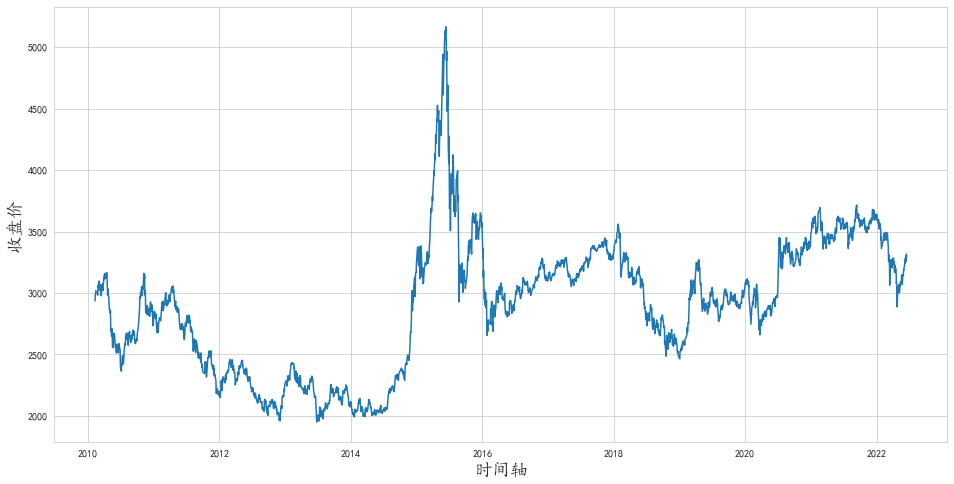

In [69]:
df["date"]=pd.to_datetime(df.date,format="%Y-%m-%d")
df.index=df['date']
plt.figure(figsize=(16,8))
plt.plot(df["close"],label='Close Price history')
plt.xlabel("时间轴",fontsize=18)
plt.ylabel("收盘价",fontsize=18)

In [70]:
#创建一个只有“Close”列数据集
data = df.filter(['close'])
##转换数据集为numpy数组
dataset = data.values

5.获取训练模型的行数

In [71]:
#Get the number of rows to train the model
training_data_len = math.ceil( len(dataset) * .8)
training_data_len

2400

6.数据规范化

In [72]:
#Scale the data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[0.30629906],
       [0.31054861],
       [0.32101331],
       ...,
       [0.4214092 ],
       [0.41518411],
       [0.42494707]])

7.创建训练数据集

In [86]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(600,len(train_data)):
    x_train.append(train_data[i-600:i,0])
    y_train.append(train_data[i,0])
    if i<= 600:
        print(x_train)
        print(y_train)
        print()

[array([0.30629906, 0.31054861, 0.32101331, 0.32194574, 0.33209207,
       0.32751077, 0.32103663, 0.3333494 , 0.34530119, 0.34260402,
       0.35376548, 0.34918449, 0.35661437, 0.33372125, 0.33611279,
       0.34300479, 0.3479511 , 0.34166631, 0.34239851, 0.33062425,
       0.31928433, 0.32422846, 0.34214885, 0.34078394, 0.34751862,
       0.34964091, 0.34297152, 0.34411661, 0.33241635, 0.34502044,
       0.36494466, 0.36639662, 0.36037642, 0.37228779, 0.37556512,
       0.37579022, 0.37253839, 0.36336242, 0.37164451, 0.36664379,
       0.37658927, 0.37812269, 0.37774431, 0.36696683, 0.32032837,
       0.32009084, 0.33680084, 0.32629386, 0.32133573, 0.31697238,
       0.29782793, 0.29546593, 0.28554813, 0.2862256 , 0.27523981,
       0.28204072, 0.24552433, 0.22956861, 0.23279401, 0.21688057,
       0.2194114 , 0.23644724, 0.23213239, 0.18963125, 0.20046718,
       0.19829825, 0.1883904 , 0.19696599, 0.22491735, 0.20912516,
       0.21010858, 0.21947482, 0.21942788, 0.19964761, 0.1922

In [90]:
x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

8.建立LSTM模型

In [91]:
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,batch_size=1,epochs=1)

1800/1800 [==============================] - 359s 199ms/step - loss: 0.0018


9.创建测试数据集

In [97]:
test_data = scaled_data[training_data_len-600:,:]
#创建数据集x test和y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(600,len(test_data)):
    x_test.append(test_data[i-600:i,0])
#转换数据为numpy数组
x_test = np.array(x_test)
#重塑的数据
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

10.获取模型预测价格值

In [98]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions

19/19 [==============================] - 3s 114ms/step


array([[3005.125 ],
       [2998.0273],
       [2992.2021],
       [2993.5483],
       [2997.172 ],
       [3008.5295],
       [3022.9358],
       [3043.1587],
       [3061.2837],
       [3074.7039],
       [3087.8914],
       [3089.9844],
       [3093.085 ],
       [3095.26  ],
       [3101.614 ],
       [3106.4736],
       [3106.2007],
       [3100.5532],
       [3094.2725],
       [3093.446 ],
       [3085.7637],
       [3078.95  ],
       [3056.0625],
       [2983.4778],
       [2914.3606],
       [2867.934 ],
       [2850.3354],
       [2850.4307],
       [2861.1604],
       [2876.5884],
       [2896.0154],
       [2908.6438],
       [2917.8884],
       [2937.3027],
       [2956.842 ],
       [2970.166 ],
       [2989.4   ],
       [3008.7783],
       [3022.242 ],
       [3026.4685],
       [3020.585 ],
       [3012.4436],
       [2981.732 ],
       [2967.4402],
       [2967.3389],
       [2977.321 ],
       [3002.305 ],
       [3020.6165],
       [3013.29  ],
       [3008.3013],


11.计算均方根误差(RMSE)

In [99]:
#原生实现 # 衡量线性回归的MSE 、 RMSE、 MAE、r2
mse = np.sum((predictions - y_test) ** 2) / len(x_test)
rmse = np.sqrt(mse)
mae = np.sum(np.absolute(predictions - y_test)) / len(x_test)
r2 = 1-mse/ np.var(y_test)#均方误差/方差
print(" MAE:",mae,"MSE:",mse," RMSE:",rmse," R^2:",r2)

 MAE: 39.9222824609375 MSE: 3155.43665403467  RMSE: 56.1732734851252  R^2: 0.9518141670752628


12.绘制图表

C:\Users\12240\AppData\Local\Temp\ipykernel_23664\388174229.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


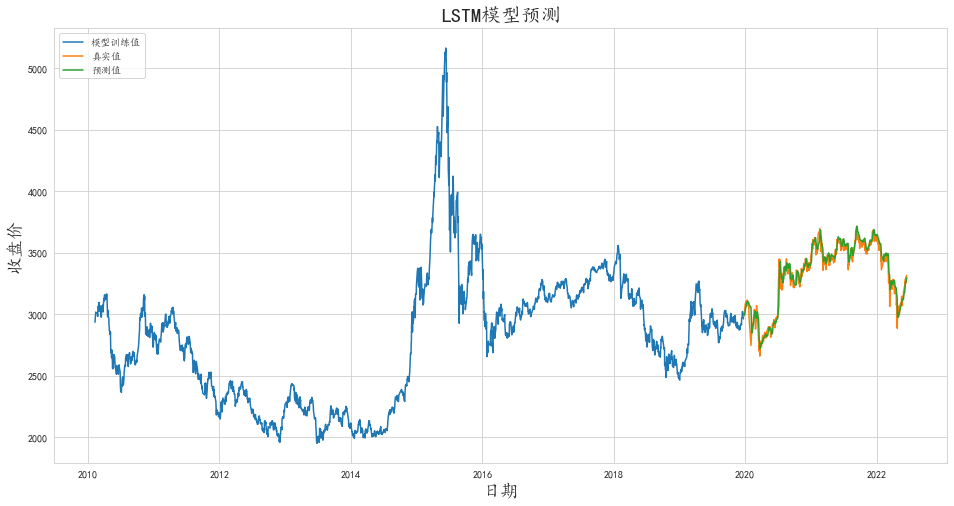

In [100]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#可视化数据
plt.figure(figsize=(16,8))
plt.title('LSTM模型预测',fontsize = 20)
plt.xlabel('日期', fontsize=18)
plt.ylabel('收盘价', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])
plt.legend(["模型训练值",'真实值','预测值'],loc='upper left')
plt.show() 